In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("processed_kelulusan.csv")
X = df.drop("Lulus", axis=1)
y = df["Lulus"]

sc = StandardScaler()
Xs = sc.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(
    Xs, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(40, 5) (9, 5) (9, 5)


In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])



model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy","AUC"])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737 (2.88 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
es = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100, batch_size=32,
    callbacks=[es], verbose=1
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 746ms/step - AUC: 0.4137 - accuracy: 0.5750 - loss: 0.7500 - val_AUC: 0.4000 - val_accuracy: 0.5556 - val_loss: 0.6858
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - AUC: 0.4825 - accuracy: 0.5250 - loss: 0.7510 - val_AUC: 0.9000 - val_accuracy: 0.5556 - val_loss: 0.6553
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - AUC: 0.5825 - accuracy: 0.6750 - loss: 0.7701 - val_AUC: 1.0000 - val_accuracy: 0.6667 - val_loss: 0.6281
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - AUC: 0.6163 - accuracy: 0.6500 - loss: 0.7675 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.6028
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - AUC: 0.7063 - accuracy: 0.7250 - loss: 0.6689 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.5791
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - AUC: 0.8025 - accuracy: 0.8000 - loss: 0.5983 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.5564
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/

In [41]:
from sklearn.metrics import classification_report, confusion_matrix

loss, acc, auc = model.evaluate(X_test, y_test, verbose=0)
print("Test Acc:", acc, "AUC:", auc)

y_proba = model.predict(X_test).ravel()
y_pred = (y_proba >= 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

Test Acc: 1.0 AUC: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
[[4 0]
 [0 5]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         4
           1      1.000     1.000     1.000         5

    accuracy                          1.000         9
   macro avg      1.000     1.000     1.000         9
weighted avg      1.000     1.000     1.000         9



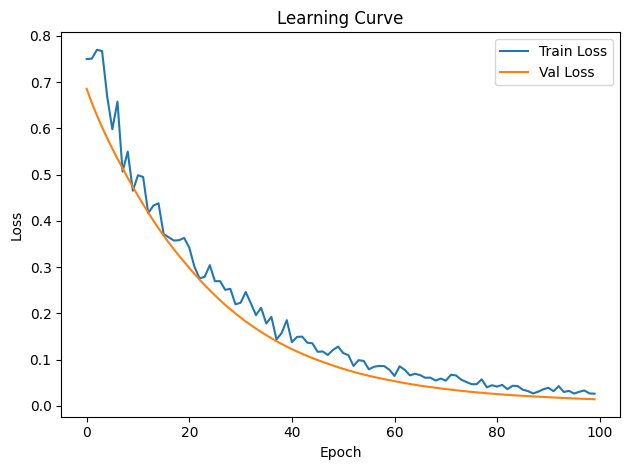

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.title("Learning Curve")
plt.tight_layout(); plt.savefig("learning_curve.png", dpi=120)